In [1]:
# Import the libraries
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer
from odc.stac import configure_rio, stac_load
import dask.distributed
import dask.utils
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
# Set up Dask client for parallel processing
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, client=client)

# Configure rio with dynamic resolution
resolution = 20
memory_limit = dask.utils.parse_bytes(client.cluster.workers[0].memory_manager.memory_limit)
SHRINK = 4
if memory_limit < dask.utils.parse_bytes("4G"):
    SHRINK = 8  # Adjust chunk size if memory is limited

resolution = resolution * SHRINK


In [4]:
# Define the area of interest (AOI) for Lake Michigan
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-88.2, 43.0],  # Lower-left corner
            [-86.1, 43.0],  # Lower-right corner
            [-86.1, 45.0],  # Upper-right corner
            [-88.2, 45.0],  # Upper-left corner
            [-88.2, 43.0],  # Closing the polygon
        ]
    ],
}

#  time span of 1 month
time_of_interest = "2023-06-01/2023-07-01"

# Query the catalog for the data
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest
)
items = list(search.items())
print(f"Returned {len(items)} Items")


Returned 101 Items


In [7]:
# Load the data from the catalog with dynamic chunking and handle missing data
xx = stac_load(
    items,
    chunks={"x": 1024 * SHRINK, "y": 1024 * SHRINK},  # Dynamically adjust chunk size
    patch_url=planetary_computer.sign,
    resolution=resolution,
    dtype="uint16",  # Handle missing data by marking nodata values
    nodata=0
)

# Display loaded data
print(f"Bands: {','.join(list(xx.data_vars))}")
display(xx)


Bands: AOT,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,SCL,WVP,visual


<xarray.Dataset> Size: 9GB
Dimensions:      (y: 3874, x: 3873, time: 18)
Coordinates:
  * y            (y) float64 31kB 5e+06 5e+06 5e+06 ... 4.69e+06 4.69e+06
  * x            (x) float64 31kB 3e+05 3.001e+05 ... 6.097e+05 6.098e+05
    spatial_ref  int32 4B 32616
  * time         (time) datetime64[ns] 144B 2023-06-01T16:28:39.024000 ... 20...
Data variables: (12/16)
    AOT          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    B01          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    B02          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    B03          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    B04          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    B05          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    ...           ...
    B11          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    B12          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    B8A          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    SCL          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    WVP          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    visual       (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>

In [8]:
# Function to convert data to float and handle missing nodata values
def to_float(xx, nodata_value=None):
    _xx = xx.astype("float32")  # Convert data to float32 for precision
    if nodata_value is None:
        nodata_value = _xx.attrs.pop("nodata", None)  # Fetch nodata value if exists
    if nodata_value is not None:
        return _xx.where(xx != nodata_value)  # Replace nodata with NaN
    return _xx

# Convert specific bands to float32 and handle missing data
b05 = to_float(xx.B05)  # Red-Edge band
b04 = to_float(xx.B04)  # Red band


In [9]:
# Calculate NDCI with small constant to avoid division by zero
ndci = (b05 - b04) / (b05 + b04 + 1e-6)

# Apply Min-Max normalization to scale NDCI between 0 and 1
ndci = (ndci - ndci.min()) / (ndci.max() - ndci.min())

# Display the calculated NDCI
display(ndci)


<xarray.DataArray (time: 18, y: 3874, x: 3873)> Size: 1GB
dask.array<truediv, shape=(18, 3874, 3873), dtype=float32, chunksize=(1, 3874, 3873), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 31kB 5e+06 5e+06 5e+06 ... 4.69e+06 4.69e+06
  * x            (x) float64 31kB 3e+05 3.001e+05 ... 6.097e+05 6.098e+05
    spatial_ref  int32 4B 32616
  * time         (time) datetime64[ns] 144B 2023-06-01T16:28:39.024000 ... 20...

In [10]:
ndci = ndci.fillna(ndci.mean())

In [11]:
chl = 826.57*(ndci**3) - 176.43*(ndci**2) + 19*(ndci) + 4.071
display(chl)

<xarray.DataArray (time: 18, y: 3874, x: 3873)> Size: 1GB
dask.array<add, shape=(18, 3874, 3873), dtype=float32, chunksize=(1, 3874, 3873), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 31kB 5e+06 5e+06 5e+06 ... 4.69e+06 4.69e+06
  * x            (x) float64 31kB 3e+05 3.001e+05 ... 6.097e+05 6.098e+05
    spatial_ref  int32 4B 32616
  * time         (time) datetime64[ns] 144B 2023-06-01T16:28:39.024000 ... 20...

In [ ]:
#print(chl.min().values, chl.max().values)

4.071 673.211


In [12]:
client.close()

In [ ]:
# print(chl.values)

In [7]:
# # Efficient concatenation of NDCI across the time dimension
# ndci_comp = xr.concat([ndci.isel(time=i) for i in range(len(ndci))], dim="time").compute()

# # Display concatenated time series
# print(ndci_comp)
# #WRONG

In [ ]:
# import dask.array as da

# # Ensure ndci is a Dask array
# ndci = ndci.chunk({"time": 1, "x": 1024, "y": 1024})

# # Concatenate using Dask arrays
# ndci_comp = da.concatenate([ndci.isel(time=i).data for i in range(ndci.sizes["time"])], axis=0)

# # Reshape the concatenated array to include the time dimension
# ndci_comp = ndci_comp.reshape((ndci.sizes["time"], ndci.sizes["y"], ndci.sizes["x"]))

# # Convert back to xarray DataArray
# ndci_comp = xr.DataArray(ndci_comp, dims=("time", "y", "x"), coords={"time": ndci.time, "y": ndci.y, "x": ndci.x})

# # Display concatenated time series
# print(ndci_comp)

In [ ]:
#pip install netCDF4

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# import numpy as np
# import xarray as xr
# import dask.distributed

# # Restart the Dask client
# client = dask.distributed.Client()
# client.restart()

# # Load the saved NetCDF file
# ndci_comp = xr.open_dataarray("ndci_comp.nc")





2024-12-03 19:58:15,541 - distributed.nanny - WARNING - Restarting worker
2024-12-03 19:58:15,543 - distributed.nanny - WARNING - Restarting worker
2024-12-03 19:58:15,550 - distributed.nanny - WARNING - Restarting worker
2024-12-03 19:58:15,558 - distributed.nanny - WARNING - Restarting worker


In [ ]:
# # Interpolate NaN values along the time dimension
# ndci_comp_interpolated = ndci.interpolate_na(dim="time", method="linear")

# # Convert the Dask array to a NumPy array
# ndci_comp_np = ndci_comp_interpolated.compute()


# ndci_rechunked = ndci.chunk(dict(time=-1))
# ndci_comp_interpolated = ndci_rechunked.interpolate_na(dim="time", method="linear")

In [ ]:
# import numpy as np
# import xarray as xr
# import dask.distributed

# # Restart the Dask client
# client = dask.distributed.Client()
# client.restart()

# # Convert the Dask array to a NumPy array
# ndci_comp_np = ndci_comp_interpolated.compute()

In [ ]:
# Select a subset of coordinates (first 100 coordinates)
#ndci_subset = ndci[:, :100, :10]

In [13]:
# Select a subset of coordinates (first 100 coordinates)
chl_subset = chl[:, :5, :5]

In [14]:
print(chl_subset.shape)

(18, 5, 5)


In [ ]:
# chl_values = chl_subset.values.reshape(-1, 1)
# print(chl_values)

[[90.86055]
 [90.86055]
 [90.86055]
 ...
 [90.86055]
 [90.86055]
 [90.86055]]


In [ ]:
# display(chl_values)

array([[90.86055],
       [90.86055],
       [90.86055],
       ...,
       [90.86055],
       [90.86055],
       [90.86055]], dtype=float32)

In [ ]:
pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 10.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.9/29.9 MB 9.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# ndci_subset = ndci_subset.fillna(ndci.mean()) #fill Nans with mean values
# # Normalize the data
# scaler = MinMaxScaler()
# ndci_values = ndci_subset.values.reshape(-1, 1)


In [ ]:
#chl_scaled = scaler.fit_transform(chl_values).reshape(chl_subset.shape)

In [ ]:
#print(chl_scaled.shape)

In [15]:
# Define a function to prepare the time series data for LSTM
def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Set time steps (e.g., using last 5 values to predict the next)
time_steps = 10
#forecast_horizon = 5  # How many future timesteps to predict
X, y = create_dataset(chl_subset, time_steps)
print(f"X shape: {X.shape}, y shape: {y.shape}")


/Users/tishyakasliwal/anaconda3/envs/gdal_env/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


X shape: (8, 10, 5, 5), y shape: (8, 5, 5)


In [16]:
print(X)

[[[[ 90.86055   90.86055   90.86055   90.86055   90.86055 ]
   [ 90.86055   90.86055   90.86055   90.86055   90.86055 ]
   [ 90.86055   90.86055   90.86055   90.86055   90.86055 ]
   [ 90.86055   90.86055   90.86055   90.86055   90.86055 ]
   [ 90.86055   90.86055   90.86055   90.86055   90.86055 ]]

  [[ 90.86055   90.86055   90.86055   90.86055   90.86055 ]
   [ 81.07416  101.3986    98.18106   92.839485  96.53696 ]
   [ 91.48515   89.15215   88.477936  85.568214  88.07674 ]
   [ 95.20924   84.15731   86.81486   86.92058   86.655   ]
   [ 87.91099   88.24988   83.50015   82.851974  84.47148 ]]

  [[ 90.86055   90.86055   90.86055   90.86055   90.86055 ]
   [ 90.86055   90.86055   90.86055   90.86055   90.86055 ]
   [ 90.86055   90.86055   90.86055   90.86055   90.86055 ]
   [ 90.86055   90.86055   90.86055   90.86055   90.86055 ]
   [ 90.86055   90.86055   90.86055   90.86055   90.86055 ]]

  ...

  [[ 90.86055   90.86055   90.86055   90.86055   90.86055 ]
   [ 89.54333   84.416626  

In [17]:
print(y)

[[[ 90.86055   90.86055   90.86055   90.86055   90.86055 ]
  [ 90.86055   90.86055   90.86055   90.86055   90.86055 ]
  [ 90.86055   90.86055   90.86055   90.86055   90.86055 ]
  [ 90.86055   90.86055   90.86055   90.86055   90.86055 ]
  [ 90.86055   90.86055   90.86055   90.86055   90.86055 ]]

 [[ 90.86055   90.86055   90.86055   90.86055   90.86055 ]
  [ 90.86055   90.86055   90.86055   90.86055   90.86055 ]
  [ 90.86055   90.86055   90.86055   90.86055   90.86055 ]
  [ 90.86055   90.86055   90.86055   90.86055   90.86055 ]
  [ 90.86055   90.86055   90.86055   90.86055   90.86055 ]]

 [[ 90.86055   90.86055   90.86055   90.86055   90.86055 ]
  [136.87057  127.630844 135.40971  142.92267  144.95062 ]
  [ 95.446655 109.30223  105.67935  115.609924 152.33385 ]
  [ 95.820564 109.844345 106.51359  105.25896  112.689735]
  [ 94.17077  105.2839   107.25084  106.19625  108.367226]]

 [[ 90.86055   90.86055   90.86055   90.86055   90.86055 ]
  [ 90.86055   90.86055   90.86055   90.86055   90

In [18]:
# Reshape the input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], chl_subset.shape[1] * chl_subset.shape[2]))
y = np.reshape(y, (y.shape[0], chl_subset.shape[1] * chl_subset.shape[2]))

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (8, 10, 25), y shape: (8, 25)


In [20]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (6, 10, 25), y_train shape: (6, 25)
X_test shape: (2, 10, 25), y_test shape: (2, 25)


In [21]:
from sklearn.preprocessing import MinMaxScaler
# Normalize input features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)

X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)

# Normalize target variable
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Reshape back to the original shape
y_train_scaled = y_train_scaled.reshape(y_train.shape)  
y_test_scaled = y_test_scaled.reshape(y_test.shape) 

In [22]:
print(X_train_scaled.shape, y_train_scaled.shape)

(6, 10, 25) (6, 25)


In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(time_steps, X.shape[2])),
    # Dropout(0.2),
    # LSTM(50, return_sequences=False),
    # Dropout(0.2),
    Dense(y.shape[1], activation='linear')
]) # Output a single value for each spatial location (the predicted next time point)
model.compile(optimizer='adam', loss='mean_squared_error')


# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        15,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,475 (64.36 KB)

 Trainable params: 16,475 (64.36 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
print(X_train.shape)
print(y_train.shape)
# Train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=5, batch_size=32, validation_split=0.2)

# # Plot the training and validation loss
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='validation')
# plt.legend()
# plt.show()



(6, 10, 25)
(6, 25)
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step - loss: 0.0820 - val_loss: 0.0254
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0713 - val_loss: 0.0193
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0630 - val_loss: 0.0153
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0566 - val_loss: 0.0128
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0517 - val_loss: 0.0113


In [25]:
# Evaluate the model
results = model.evaluate(X_test_scaled, y_test_scaled)
print(f"Model loss (MSE): {results}")
print("RMSE: ", np.sqrt(results))

# Make predictions
predictions = model.predict(X_test_scaled)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1065
Model loss (MSE): 0.10653897374868393
RMSE:  0.32640308477200997
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
[[ 0.01704171  0.10702174  0.04167575  0.03647328 -0.1319801   0.1482795
   0.0896837  -0.14244846  0.03605213  0.13631642  0.0606319   0.08543149
   0.02674319  0.05084912  0.2130483  -0.01530265 -0.08294054  0.03190431
   0.04328051 -0.02123777 -0.0434577  -0.00318018  0.09328596  0.03841962
   0.07380579]
 [-0.00296997  0.12917353  0.07412394  0.05513041 -0.17253734  0.13943323
   0.07734964 -0.1683666   0.0453011   0.11512262  0.07166016  0.11895877
   0.02238144  0.04490753  0.24287407 -0.03027391 -0.05614369  0.03906044
   0.04567835 -0.01218325 -0.05172642 -0.02156051  0.11880458  0.04781562
   0.08876313]]


In [26]:
print(predictions.shape)

(2, 25)


In [27]:
print(y_test_scaled.min(), y_test_scaled.max())

0.0 1.0982733


In [28]:
print(predictions.min(), predictions.max())

-0.17253734 0.24287407


In [29]:
y_pred = scaler_y.inverse_transform(predictions.reshape(-1, 1))

# Reshape the predictions back to the original shape
y_pred = y_pred.reshape(y_test.shape)

In [30]:
print(y_pred.min(), y_pred.max())

80.25411 105.79082


In [31]:
print(y_pred.shape)

(2, 25)


In [32]:
print(y_pred)
print(y_test)

[[ 91.90816   97.43953   93.4225    93.102684  82.7473    99.975784
   96.3737    82.103775  93.07679   99.24037   94.58779   96.112305
   92.50454   93.98641  103.95734   89.919846  85.76192   92.821815
   93.52115   89.555     88.18906   90.665054  96.595146  93.22233
   95.39764 ]
 [ 90.67798   98.80127   95.4172    94.249596  80.25411   99.43198
   95.615486  80.510506  93.645355  97.93752   95.26574   98.17333
   92.23641   93.62117  105.79082   88.99951   87.40922   93.26173
   93.66855   90.1116    87.680756  89.53516   98.16386   93.799934
   96.317116]]
[[ 90.86055   90.86055   90.86055   90.86055   90.86055   90.86055
   90.86055   90.86055   90.86055   90.86055   90.86055   90.86055
   90.86055   90.86055   90.86055   90.86055   90.86055   90.86055
   90.86055   90.86055   90.86055   90.86055   90.86055   90.86055
   90.86055 ]
 [ 90.86055   90.86055   90.86055   90.86055   90.86055  146.37617
  133.58719  145.77573  148.40771  149.33287   96.43858  106.84922
  105.571396 11

In [ ]:
# import numpy as np

# # Save predictions as a Numpy .npy file
# np.save("predictions.npy", y_pred)
# np.save("y_test.npy", y_test)

In [33]:
# Reshape y_test_inverse back to its original shape
y_test_inverse = y_test.reshape((y_test.shape[0], chl_subset.shape[1], chl_subset.shape[2]))
print(y_test_inverse)

[[[ 90.86055   90.86055   90.86055   90.86055   90.86055 ]
  [ 90.86055   90.86055   90.86055   90.86055   90.86055 ]
  [ 90.86055   90.86055   90.86055   90.86055   90.86055 ]
  [ 90.86055   90.86055   90.86055   90.86055   90.86055 ]
  [ 90.86055   90.86055   90.86055   90.86055   90.86055 ]]

 [[ 90.86055   90.86055   90.86055   90.86055   90.86055 ]
  [146.37617  133.58719  145.77573  148.40771  149.33287 ]
  [ 96.43858  106.84922  105.571396 118.62463  158.37503 ]
  [ 95.59912  107.11582  106.12003  102.52777  118.35835 ]
  [ 94.03455  103.83107  106.03474  105.89582  105.6617  ]]]


In [34]:
print(y_test_inverse.shape)

(2, 5, 5)


In [35]:
# Reshape y_test_inverse back to its original shape
y_pred_inverse = y_pred.reshape((y_pred.shape[0], chl_subset.shape[1], chl_subset.shape[2]))
print(y_pred_inverse.shape)

(2, 5, 5)


In [ ]:
# # Select a timestep to visualize (e.g., the first timestep in the test set)
# timestep = 0

# # Extract the data for the selected timestep
# y_pred_timestep = y_pred_inverse[timestep]

# # Create the visualization
# plt.figure(figsize=(8, 6))
# plt.imshow(y_pred_timestep, cmap='viridis', aspect='auto')
# plt.colorbar(label='Chlorophyll Value')
# plt.title(f'Predicted Chlorophyll Values at Timestep {timestep}')
# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.show()

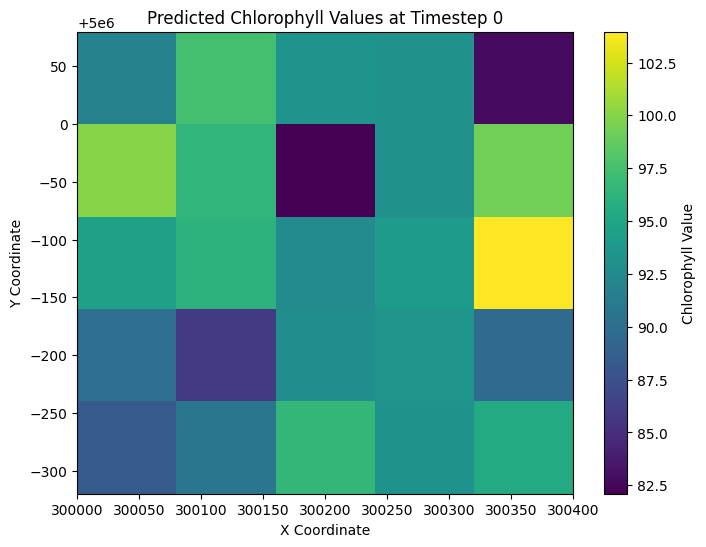

In [39]:
# Select a timestep to visualize (e.g., the first timestep in the test set)
timestep = 0

# Extract the data for the selected timestep
y_pred_timestep = y_pred_inverse[timestep]

# Extract the actual coordinates
x_coords = chl_subset.coords['x'].values
y_coords = chl_subset.coords['y'].values

# Create the visualization
plt.figure(figsize=(8, 6))
plt.pcolormesh(x_coords, y_coords, y_pred_timestep, cmap='viridis', shading='auto')
plt.colorbar(label='Chlorophyll Value')
plt.title(f'Predicted Chlorophyll Values at Timestep {timestep}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

In [ ]:
# # Plot some predictions
# plt.figure(figsize=(10, 6))
# plt.plot(chl_subset.coords['time'].values[:len(y_pred_inverse)], y_pred_inverse[:, 0, 0], label='Predicted')
# plt.plot(chl_subset.coords['time'].values[:len(y_pred_inverse)], y_test_inverse[:len(y_pred_inverse), 0, 0], label='Actual')
# plt.legend()
# plt.show()

In [44]:
# Start with the most recent input sequence
current_input = X_test_scaled[0]
current_input = X_test[0].reshape(1, time_steps, X.shape[2])  # Reshape to [samples, time_steps, features]
n_future_steps = 4
future_predictions = []
for _ in range(n_future_steps):
    # Predict the next timestep
    pred = model.predict(current_input)
    
    # Append the prediction to the list
    future_predictions.append(pred)
    
    # Update the input sequence: add the prediction and remove the oldest timestep
    current_input = np.append(current_input[:, 1:, :], pred.reshape(1, 1, -1), axis=1)

# Combine all predictions
future_predictions = np.array(future_predictions)
print(future_predictions.shape)
print(future_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
(4, 1, 25)
[[[-0.5799989   0.6326678   0.14990842 -0.23991376 -0.2694969
   -0.27676678 -0.3257388   0.35569075 -0.331163    0.12217958
    0.71542084  0.7528673  -0.6529646   0.07365132 -0.58213574
    0.41463345 -0.08677759 -0.04259677  0.0868023  -0.09295968
    0.85908884 -0.01215853 -0.66670007  0.5380966   0.08153903]]

 [[-0.39546216  0.5685883   0.18510814 -0.13312642 -0.33231962
   -0.26615125 -0.09853625  0.33979508  0.17232284  0.17307863
    0.32739064  0.45861226 -0.27522263  0.05155105  0.02701689
    0.41265684  0.26075318  0.18005142 -0.51930916  0.03936028
    0.6321186  -0.01930667  0.13528547  0.57930154  0.3634729 ]]

 [[-0.3952501   0.60469085  0.18337084 -0.2577441  -0.3349341
   -0.22760934 -0.1807735   0.34942123  0.2025565   0.16700153
    0.30273014  0.47830296 -0.4025234  -0.03280021  0.09480635
    0.2986589 

In [45]:
# Optionally, inverse transform the predictions
future_predictions = scaler_y.inverse_transform(future_predictions.reshape(-1, 1))
future_predictions = future_predictions.reshape(n_future_steps, -1)
print(future_predictions)
print(future_predictions.shape)

[[ 55.206104 129.75273  100.07592   76.11227   74.293686  73.84679
   70.83631  112.726036  70.50288   98.37134  134.83984  137.14178
   50.720665  95.38814   55.074745 116.34944   85.52605   88.24198
   96.19657   85.14601  143.67159   90.11313   49.876297 123.939125
   95.873024]
 [ 66.550186 125.813545 102.23976   82.676834  70.43177   74.49936
   84.8032   111.74888  101.453804 101.50027  110.986336 119.052956
   73.9417    94.029564  92.52137  116.22793  106.88991  101.92891
   58.936905  93.28016  129.71896   89.673706  99.176994 126.47213
  113.20443 ]
 [ 66.563225 128.03288  102.13296   75.016174  70.27105   76.86865
   79.74781  112.34063  103.31237  101.126686 109.47037  120.26341
   66.11611   88.844215  96.68861  109.22009  104.7925   102.36207
   62.976723  92.12622  129.25534   93.18392   95.040054 124.877075
  114.69292 ]
 [ 67.68302  128.25668  100.9888    71.49409   69.46854   76.11635
   76.72577  113.178375 104.97293  101.93075  106.91132  117.945724
   62.884758  83

In [ ]:
# import numpy as np

# # Assuming y_pred_lstm_grid is the prediction you want to save
# np.save('predicted_ndci.npy', y_pred)


In [ ]:
# import matplotlib.pyplot as plt
# # Train the model
# history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# # Plot the training and validation loss
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='validation')
# plt.legend()
# plt.show()

# # Evaluate the model
# loss = model.evaluate(X_test, y_test)
# print(f"Model loss: {loss}")

# # Make predictions
# predictions = model.predict(X)
# print(predictions)
# # Reshape predictions to the original shape
# predictions = predictions.reshape((predictions.shape[0], chl_subset.shape[1], chl_subset.shape[2]))

# # Inverse transform the predictions
# predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(predictions.shape)

# # Plot some predictions
# plt.figure(figsize=(10, 6))
# plt.plot(chl.coords['time'].values[:len(predictions)], predictions[:, 0, 0], label='Predicted')
# plt.plot(chl.coords['time'].values[:len(predictions)], chl_subset[:len(predictions), 0, 0], label='Actual')
# plt.legend()
# plt.show()

In [ ]:
# # Check for NaN or infinite values in the data
# if np.isnan(ndci_comp_np_subset).any() or np.isinf(ndci_comp_np_subset).any():
#     raise ValueError("Input data contains NaN or infinite values.")
